## Underfitting versus Overfitting

Un problema típico cuando se modela en Aprendizaje automático es la compensación entre varianza y bias. Lo que produce en sus extremos modelos con underfitting, que no predicen bien siendo muy bias o modelos con everfitting que se ajuntan mucho a los datos y no son capaces de generalizar de forma adecuada.


Vamos a ver con un ejemplo simulado ambos efectos.

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn import datasets
%matplotlib inline

In [9]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

## Simulación de datos.

Vamos a simular 500 puntos $(x_i, y_i)$ que cumplen la fórmula o modelo siguiente:

$$y = 2 x^3 - x^2 + x + 1 + \varepsilon_i$$

donde $\varepsilon_i$ sigue una distribución normal con media  $\mu = 0$ y desviación típica $\sigma=2$.

Simulamos primero 1000 puntos $x_i$ del intervalo $(-2, 2)$.

In [3]:
N = 60
np.random.seed(seed=666)
x = np.random.uniform(-2, 2, N)

Ahora evaluamos estos puntos en la fórmula anterior dada teniendo los valores  $y_i$.

In [6]:
sigma = 2
epsilon = np.random.normal(loc=0, scale=sigma, size=N)

f = lambda x: 2 * x**3 - x**2 + x + 1
y = f(x) + epsilon

Dibujemos ahora los valores:  $x_i$, $f(x_i)$ and $y_i$.

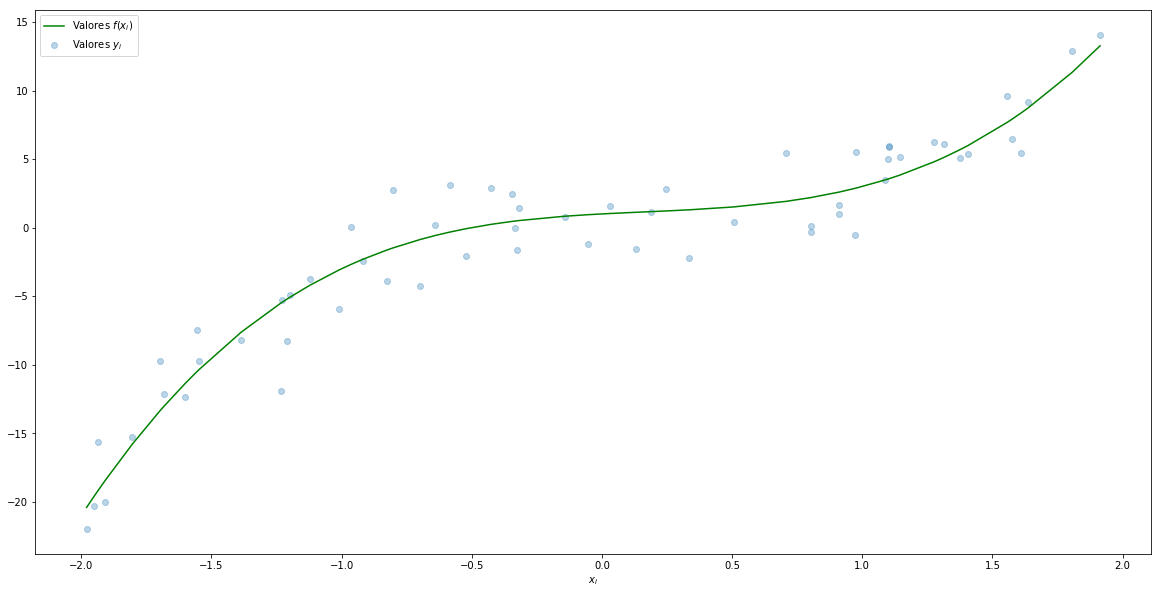

In [15]:
plt.scatter(x, y, alpha=0.3)
x_sorted = np.sort(x)
plt.plot(x_sorted, f(x_sorted), c="green")
plt.xlabel("$x_i$")
plt.legend(["Valores $f(x_i)$","Valores $y_i$"])

## Modelamiento

Vamos a construir un modelo que pueda predecir los valores $y_i$. Este modelo los definimos como sigue:


$$y = a_1 x + a_2 x^2 + a_3 x^3 + b.$$

Aquí los valores esperados deberían que $a_1$, $a_2$, $a_3$ y $b$ son lo más cercano a $1$, $-1$, $2$ amd $1$ respectivamente.

¿Cómo construir este modelo? La clave es unar regresión lineal múltiple con
nuevos predictores que surgen de un cambio de variable:
    
    
$x_1=x$, 

$x_2=x^2$, 

$x_3=x^3$. 


Así el modelo que vamos a entrenar tiene la forma:

$$y = a_1 x_1 + a_2 x_2 + a_3 x_3 + b.$$

Por tanto reducimos nuestro problema a un problema de regresion lineal múltiple
que resolvemos  siguiendo los 5 pasos dados en los capítulos anteriores.

### Preparación de las nuevas columnas de datos

Creación de una función que calcule las nuevas columnas de datos
$x$, $x^2$ y $x^3$.

In [18]:
# 1. Create a function that prepare data with columns x, x^2 and x^3
def create_dataset_with_powers(x, max_power=3):
    x_column = np.expand_dims(x, 1) # this change vector to columns
    return np.concatenate([x_column**i for i in range(1, max_power+1)], axis=1)

In [21]:
# 2. Separación de los datos en entrenamiento y test.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)
X_train = create_dataset_with_powers(x_train)
X_test = create_dataset_with_powers(x_test)

# 3. Construccion del modelo
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

# 4. Ajuste del modelo al conjunto de datos entrenamiento.
reg.fit(X_train, y_train)

# 5. Evaluación del modelo en el test
from sklearn.metrics import mean_squared_error, r2_score

y_test_hat = reg.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_test_hat)))
print("R^2 score: ", r2_score(y_test, y_test_hat))

RMSE:  2.585462286189062
R^2 score:  0.745491314556376


** Conclusión**: Hemos calculado un buen modelo que predice bien. 
Dibujamos la solución:

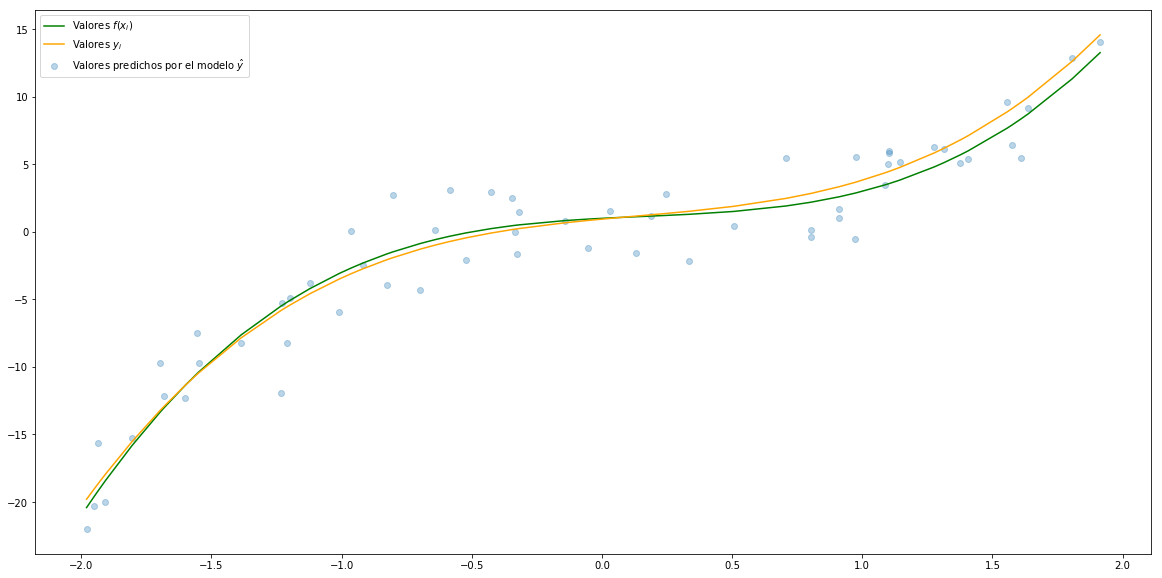

In [25]:
plt.scatter(x, y, alpha=0.3)
x_sorted = np.sort(x)
plt.plot(x_sorted, f(x_sorted), c="green")
plt.plot(x_sorted, reg.predict(create_dataset_with_powers(x_sorted)), c="orange")
plt.legend(["Valores $f(x_i)$","Valores $y_i$", "Valores predichos por el modelo $\hat y $"])

Si calculamos el valor de los coeficientes, vemos que están muy cerca de los valores reales predefinidos:

In [27]:
reg.coef_, reg.intercept_

(array([ 1.76884379, -0.73787104,  1.84915327]), 0.9413002666985193)

### Efecto de underfitting y overfitting

En este caso teníamos el valor real de la función, pero en general esto es desconocido.
Entonces si buscamos una función polinomial que se ajuste a nuestros datos, ¿cúal es el grado mñas adecuado?

La manera de hacerlo es muy parecida al método de selección de predictores
creando antes nuevos predictores del predictor $x$ como potencias de $x$: 

$x^2$,$x^3$,$x^4$,$x^5$,$x^6$


In [28]:
# 1. Create a function that prepare data with columns $n$ columns x  x^2 ... x^n 
# Already done, see function create_dataset_with_powers

# 2. Split data into train, dev and test.

x_train_dev, x_test, y_train_dev, y_test = train_test_split(x, y, random_state=666, test_size=0.2)
x_train, x_dev, y_train, y_dev = train_test_split(x_train_dev, y_train_dev, random_state=667, test_size=0.25)

# 3. Create a function that build polynomial model of degree n, fit it and report performance on dev.

def evalute_polinomial_model(degree, x_train, x_test, y_train, y_test):
    X_train = create_dataset_with_powers(x_train, degree)
    X_test = create_dataset_with_powers(x_test, degree)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_train_hat = reg.predict(X_train)
    y_test_hat = reg.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_hat)
    mse_test = mean_squared_error(y_test, y_test_hat)
    return np.sqrt(mse_train), np.sqrt(mse_test), reg

# 4. Evaluate different models and record performance.
MAX_DEGREE = 20
performance = pd.DataFrame()
regs = []

for degree in range(1, MAX_DEGREE+1):
    mses = evalute_polinomial_model(degree, x_train, x_dev, y_train, y_dev)
    new_row = pd.DataFrame({
        "degree": [degree], 
        "RMSE_train": [mses[0]],
        "RMSE_dev": [mses[1]]
    })
    performance = performance.append(new_row, ignore_index = True)
    regs.append(mses[2])
    
# 5. Choose best model.
performance.set_index("degree")

,RMSE_dev,RMSE_train
degree,,
1,4.740615,3.422577
2,3.627597,3.188711
3,2.740439,2.046876
4,3.078638,1.964755
5,3.322722,1.929144
6,3.318030,1.929073
7,2.968573,1.889613
8,2.970363,1.889498
9,3.081439,1.878140


In [29]:
# 6. Retrain the best model on both train and dev and evaluate on test data.

evalute_polinomial_model(3, x_train_dev, x_test, y_train_dev, y_test)

(2.221396603531215,
 2.025259830736694,
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))

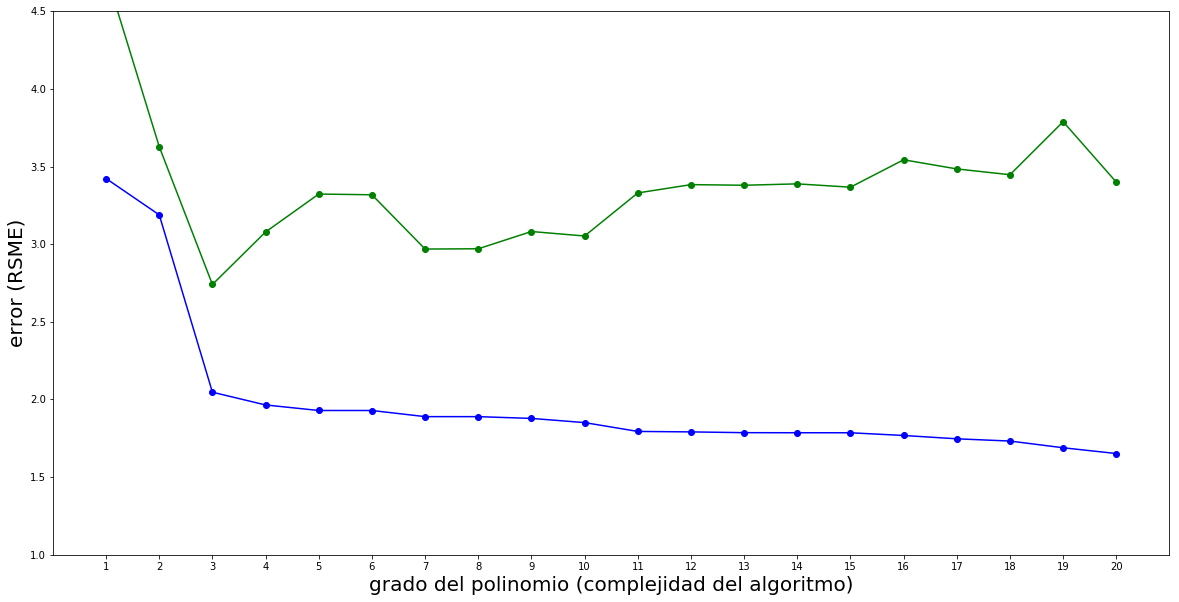

In [39]:
plt.scatter(performance["degree"], performance["RMSE_train"], c="blue")
plt.plot(performance["degree"], performance["RMSE_train"], c="blue")
plt.scatter(performance["degree"], performance["RMSE_dev"], c="green")
plt.plot(performance["degree"], performance["RMSE_dev"],c="green")
plt.xticks(performance["degree"])
plt.ylim((1, 4.5))
plt.ylabel("error (RSME)",size=20)
plt.xlabel("grado del polinomio (complejidad del algoritmo)",size=20)
plt.show()

Y podemos concluir que grado 3 puede ser una buena elección de modelo.
Dibujamos abajo algunas de las grñaficas para pdoer ver el efecto de overfitting y underfitting.

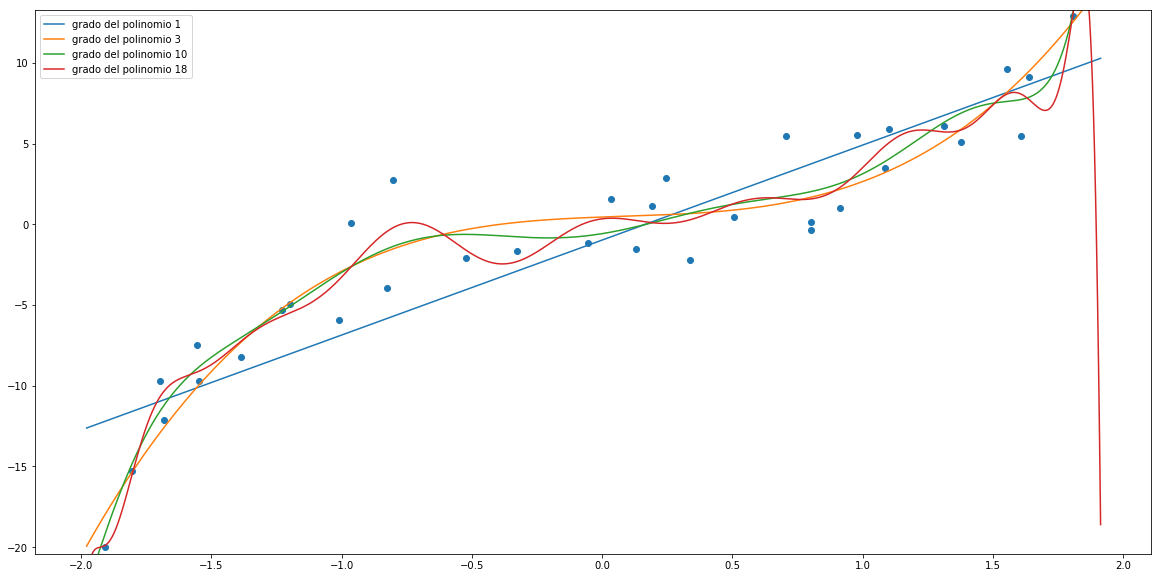

In [49]:
xs = np.linspace(np.min(x), np.max(x), num=1000)
plt.ylim((np.min(f(xs)), np.max(f(xs))))
plt.scatter(x_train, y_train)
for degree in [1, 3, 10, 18]:
    Xs = create_dataset_with_powers(xs, degree)
    ys = regs[degree-1].predict(Xs)
    plt.plot(xs, ys, alpha=1, label="grado del polinomio " + str(degree))
plt.legend()